In [ ]:
from lib.data_utils import *
from lib.model_utils import *
from lib.simulator import *

from glob import glob
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import lib.draw as draw

In [2]:
df_train, df_train_y, df_optimization, df_optimization_y, df_test, df_test_y, complete_feature_set, features_model = load_model_training_data_template(train_sets = [], optimization_sets = [], test_sets = ['data/wyscout/csv/events/Spain.csv', 'data/wyscout/csv/events/England.csv'])

In [3]:
df = df_test.reset_index(drop=True).copy()

In [4]:
df['h'] = 0
df['d'] = 0
df['a'] = 0
for fname in tqdm(glob('data/lem/*.csv')):
    df_sim = pd.read_csv(fname)
    df['h'] += (df_sim.home_score > df_sim.away_score).astype(int)
    df['d'] += (df_sim.home_score == df_sim.away_score).astype(int)
    df['a'] += (df_sim.home_score < df_sim.away_score).astype(int)

100%|██████████| 254/254 [04:33<00:00,  1.08s/it]


In [5]:
df['prob_h'] = df.h / (df.h + df.d + df.a)
df['prob_d'] = df.d / (df.h + df.d + df.a)
df['prob_a'] = df.a / (df.h + df.d + df.a)
df['exp_pts_home'] = df.prob_h * 3 + df.prob_d * 1
df['exp_pts_away'] = df.prob_a * 3 + df.prob_d * 1
df['exp_pts_before'] = (df.exp_pts_home.shift(1) * df.is_home_team + df.exp_pts_away.shift(1) * (1 - df.is_home_team))
df['exp_pts_in'] = (df.exp_pts_home * df.is_home_team + df.exp_pts_away * (1 - df.is_home_team))
df['exp_pts_after'] = (df.exp_pts_home.shift(-1) * df.is_home_team + df.exp_pts_away.shift(-1) * (1 - df.is_home_team))
df['exp_pts_increase_before_after'] = df.exp_pts_after - df.exp_pts_before
df['exp_pts_increase_in_after'] = df.exp_pts_after - df.exp_pts_in
df['exp_pts_increase_before_in'] = df.exp_pts_in - df.exp_pts_before

In [6]:
df['is_same_game'] = (df.match_id == df.match_id.shift(1)) & (df.match_id == df.match_id.shift(-1))
df['exp_pts_increase_before_after'] = df.exp_pts_increase_before_after * df.is_same_game
df['exp_pts_increase_in_after'] = df.exp_pts_increase_in_after * df.is_same_game
df['exp_pts_increase_before_in'] = df.exp_pts_increase_before_in * df.is_same_game

In [7]:
df

,id,match_id,match_name,match_winner,home_team_id,away_team_id,absolute_sec,minute,second,period,...,prob_a,exp_pts_home,exp_pts_away,exp_pts_before,exp_pts_in,exp_pts_after,exp_pts_increase_before_after,exp_pts_increase_in_after,exp_pts_increase_before_in,is_same_game
0,180864419,2565548,Levante - Villarreal,695,695,682,3.0,0.000000,2,0,...,0.314961,1.566929,1.188976,NaN,1.188976,1.267717,NaN,0.000000,NaN,False
1,180864418,2565548,Levante - Villarreal,695,695,682,3.1,0.000000,3,0,...,0.350394,1.515748,1.267717,1.188976,1.267717,1.330709,0.141732,0.062992,0.078740,True
2,180864420,2565548,Levante - Villarreal,695,695,682,6.7,0.000000,6,0,...,0.350394,1.389764,1.330709,1.267717,1.330709,1.322835,0.055118,-0.007874,0.062992,True
3,180864421,2565548,Levante - Villarreal,695,695,682,8.8,0.000000,8,0,...,0.350394,1.405512,1.322835,1.330709,1.322835,1.374016,0.043307,0.051181,-0.007874,True
4,180864422,2565548,Levante - Villarreal,695,695,682,14.0,0.000000,14,0,...,0.385827,1.409449,1.374016,1.322835,1.374016,1.299213,-0.023622,-0.074803,0.051181,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214833,251596408,2500098,West Ham United - Everton,1633,1633,1623,2790.5,0.766667,30,1,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
1214834,251596232,2500098,West Ham United - Everton,1633,1633,1623,2829.8,0.783333,9,1,...,0.000000,3.000000,0.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,True
1214835,251596410,2500098,West Ham United - Everton,1633,1633,1623,2831.2,0.783333,11,1,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
1214836,251596234,2500098,West Ham United - Everton,1633,1633,1623,2832.4,0.783333,12,1,...,0.000000,3.000000,0.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,True


In [8]:
pd.concat([
    df.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    #df.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum().sort_values(ascending=False).tail(20).reset_index(),
    df.groupby(['player_name', 'team_name']).exp_pts_increase_in_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    #df.groupby(['player_name', 'team_name']).exp_pts_increase_in_after.sum().sort_values(ascending=False).tail(20).reset_index(),
    df.groupby(['player_name', 'team_name']).exp_pts_increase_before_in.sum().sort_values(ascending=False).head(20).reset_index(),
    #df.groupby(['player_name', 'team_name']).exp_pts_increase_before_in.sum().sort_values(ascending=False).tail(20).reset_index(),
    ], axis=1)

,player_name,team_name,exp_pts_increase_before_after,player_name,team_name,exp_pts_increase_in_after,player_name,team_name,exp_pts_increase_before_in
0,Mohamed Salah,Liverpool,30.858268,Dani Parejo,Valencia,17.925197,Mohamed Salah,Liverpool,25.480315
1,R. Mahrez,Leicester City,30.334646,R. Mahrez,Leicester City,17.377953,H. Kane,Tottenham Hotspur,16.204724
2,Maxi Gómez,Celta de Vigo,18.271654,F. Vázquez,Sevilla,12.653543,R. Sterling,Manchester City,15.610236
3,L. Messi,Barcelona,17.425197,S. Cook,AFC Bournemouth,11.055118,A. Barnes,Burnley,15.232283
4,K. De Bruyne,Manchester City,16.696850,N. Matić,Manchester United,10.874016,Maxi Gómez,Celta de Vigo,14.610236
5,A. Griezmann,Atlético Madrid,16.346457,M. Lanzini,West Ham United,10.043307,Gerard Moreno,Espanyol,12.984252
6,H. Kane,Tottenham Hotspur,15.775591,A. Smith,AFC Bournemouth,9.692913,R. Mahrez,Leicester City,12.956693
7,M. Arnautović,West Ham United,14.366142,M. Lowton,Burnley,9.657480,Santi Mina,Valencia,12.929134
8,L. Suárez,Barcelona,14.358268,R. Varane,Real Madrid,9.559055,A. Griezmann,Atlético Madrid,12.708661
9,Richarlison,Watford,14.110236,M. Jørgensen,Huddersfield Town,9.492126,Luisinho,Deportivo La Coruña,12.629921


In [9]:
print(pd.concat([
    df.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum().sort_values(ascending=False).head(10).rename('xPts+').reset_index(), 
    ], axis=1).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llr}
\toprule
  player\_name &         team\_name &  xPts+ \\
\midrule
Mohamed Salah &         Liverpool &  30.86 \\
    R. Mahrez &    Leicester City &  30.33 \\
   Maxi Gómez &     Celta de Vigo &  18.27 \\
     L. Messi &         Barcelona &  17.43 \\
 K. De Bruyne &   Manchester City &  16.70 \\
 A. Griezmann &   Atlético Madrid &  16.35 \\
      H. Kane & Tottenham Hotspur &  15.78 \\
M. Arnautović &   West Ham United &  14.37 \\
    L. Suárez &         Barcelona &  14.36 \\
  Richarlison &           Watford &  14.11 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8284/3573384025.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([


In [10]:
df_shots = df[df.type_name == 'shot']
pd.concat([
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_in_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_before_in.sum().sort_values(ascending=False).head(20).reset_index(),
    ], axis=1)

,player_name,team_name,exp_pts_increase_before_after,player_name,team_name,exp_pts_increase_in_after,player_name,team_name,exp_pts_increase_before_in
0,Mohamed Salah,Liverpool,15.598425,Ángel,Getafe,2.145669,Mohamed Salah,Liverpool,16.759843
1,H. Kane,Tottenham Hotspur,14.649606,Cristiano Ronaldo,Real Madrid,1.972441,L. Messi,Barcelona,14.728346
2,L. Messi,Barcelona,14.086614,A. Sánchez,Arsenal,1.685039,H. Kane,Tottenham Hotspur,13.688976
3,Gerard Moreno,Espanyol,13.854331,Gerard Moreno,Espanyol,1.633858,L. Suárez,Barcelona,12.582677
4,L. Suárez,Barcelona,13.578740,Pablo Maffeo,Girona,1.602362,Maxi Gómez,Celta de Vigo,12.440945
5,Cristiano Ronaldo,Real Madrid,13.346457,J. Hendrick,Burnley,1.425197,R. Mahrez,Leicester City,12.279528
6,Maxi Gómez,Celta de Vigo,12.673228,E. Hazard,Chelsea,1.417323,Gerard Moreno,Espanyol,12.220472
7,R. Mahrez,Leicester City,11.208661,Iñaki Williams,Athletic Club,1.299213,Cristiano Ronaldo,Real Madrid,11.374016
8,R. Sterling,Manchester City,10.665354,Óscar Melendo,Espanyol,1.295276,R. Sterling,Manchester City,10.822835
9,Ángel,Getafe,10.405512,Y. Cabaye,Crystal Palace,1.240157,G. Bale,Real Madrid,9.377953


In [11]:
df.type_name.value_counts()

pass                       647379
duel                       348738
others_on_the_ball          99412
free_kick                   74495
foul                        19103
shot                        16430
save_attempt                 6759
goalkeeper_leaving_line      2522
Name: type_name, dtype: int64

In [12]:
df['name_team'] = df.player_name.astype(str)# + ' (' + df.team_name + ')'
df_shots = df[df.type_name == 'shot']
df_pass = df[df.type_name == 'pass']
df_duel = df[(df.type_name == 'duel') & (df.player_name != 0)]

print(pd.concat([
    df_shots.groupby('name_team').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(10).rename('Shot xPts+').reset_index(), 
    df_pass.groupby('name_team').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(10).rename('Pass xPts+').reset_index(), 
    df_duel.groupby('name_team').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(10).rename('Duel xPts+').reset_index(),
    ], axis=1).to_latex(index=False, float_format="%.2f").replace(' Hotspur','        ').replace('United', 'Utd.  '))

\begin{tabular}{lrlrlr}
\toprule
        name\_team &  Shot xPts+ &     name\_team &  Pass xPts+ &     name\_team &  Duel xPts+ \\
\midrule
    Mohamed Salah &       15.60 &  K. De Bruyne &       14.09 & Mohamed Salah &       12.66 \\
          H. Kane &       14.65 & M. Albrighton &       12.55 &     C. Stuani &        7.43 \\
         L. Messi &       14.09 &     R. Mahrez &       10.69 &   Richarlison &        6.43 \\
    Gerard Moreno &       13.85 &   Dani Parejo &       10.34 &     R. Mahrez &        6.19 \\
        L. Suárez &       13.58 & Pablo Fornals &        9.99 &     A. Lennon &        5.94 \\
Cristiano Ronaldo &       13.35 &    Jordi Alba &        9.67 &      Portillo &        5.89 \\
       Maxi Gómez &       12.67 &      Barragán &        9.13 &        Nolito &        5.88 \\
        R. Mahrez &       11.21 &      P. Pogba &        8.55 &    C. Benteke &        5.33 \\
      R. Sterling &       10.67 &    S. Francis &        8.37 &      Casemiro &        5.31 \\
     

/tmp/ipykernel_8284/498602426.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([


In [13]:
df_shots = df[df.type_name == 'pass']
pd.concat([
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_in_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df_shots.groupby(['player_name', 'team_name']).exp_pts_increase_before_in.sum().sort_values(ascending=False).head(20).reset_index(),
    ], axis=1)

,player_name,team_name,exp_pts_increase_before_after,player_name,team_name,exp_pts_increase_in_after,player_name,team_name,exp_pts_increase_before_in
0,K. De Bruyne,Manchester City,14.090551,Dani Parejo,Valencia,15.460630,Fàbregas,Chelsea,9.708661
1,M. Albrighton,Leicester City,12.547244,K. De Bruyne,Manchester City,12.165354,Sergio Ramos,Real Madrid,8.236220
2,R. Mahrez,Leicester City,10.688976,Jordi Alba,Barcelona,10.720472,Pablo Fornals,Villarreal,8.078740
3,Dani Parejo,Valencia,10.342520,D. Alli,Tottenham Hotspur,10.456693,B. Davies,Tottenham Hotspur,7.948819
4,Pablo Fornals,Villarreal,9.992126,M. Albrighton,Leicester City,9.874016,G. Wijnaldum,Liverpool,7.803150
5,Jordi Alba,Barcelona,9.665354,M. Jørgensen,Huddersfield Town,9.342520,L. Modrić,Real Madrid,7.700787
6,Barragán,Real Betis,9.125984,J. Gomez,Liverpool,8.078740,H. Maguire,Leicester City,7.330709
7,P. Pogba,Manchester United,8.551181,F. Vázquez,Sevilla,7.870079,S. Francis,AFC Bournemouth,7.157480
8,S. Francis,AFC Bournemouth,8.374016,Sergi Roberto,Barcelona,7.767717,Tomás Pina,Deportivo Alavés,7.157480
9,M. Lanzini,West Ham United,7.661417,M. Lowton,Burnley,7.594488,S. Savić,Atlético Madrid,6.362205


In [14]:
pd.concat([
    df[df.team_name == 'Barcelona'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df[df.team_name == 'Barcelona'].groupby('player_name').exp_pts_increase_in_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    df[df.team_name == 'Barcelona'].groupby('player_name').exp_pts_increase_before_in.sum().sort_values(ascending=False).head(20).reset_index(),
    ], axis=1)

,player_name,exp_pts_increase_before_after,player_name,exp_pts_increase_in_after,player_name,exp_pts_increase_before_in
0,L. Messi,17.425197,Jordi Alba,8.015748,L. Messi,10.374016
1,L. Suárez,14.358268,L. Messi,7.051181,L. Suárez,9.665354
2,Jordi Alba,11.153543,Sergi Roberto,5.362205,Sergio Busquets,8.370079
3,T. Vermaelen,5.133858,T. Vermaelen,4.925197,I. Rakitić,5.003937
4,Philippe Coutinho,4.925197,L. Suárez,4.692913,Piqué,4.913386
5,Paco Alcácer,4.397638,Paulinho,3.370079,Paco Alcácer,4.389764
6,I. Rakitić,4.153543,Philippe Coutinho,3.287402,Jordi Alba,3.137795
7,Sergio Busquets,4.043307,S. Umtiti,3.133858,O. Dembélé,2.980315
8,O. Dembélé,3.303150,0,2.188976,J. Mascherano,2.704724
9,Sergi Roberto,2.267717,Denis Suárez,2.031496,Iniesta,2.437008


In [45]:
df = df[df.player_name != 0]
print(pd.concat([
    df[df.team_name == 'Barcelona'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(), 
    df[df.team_name == 'Real Madrid'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(), 
    df[df.team_name == 'Atlético Madrid'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(),
    df[df.team_name == 'Valencia'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(),
    ], axis=1).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrlrlrlr}
\toprule
      player\_name &  xPts+ &       player\_name &  xPts+ &  player\_name &  xPts+ &  player\_name &  xPts+ \\
\midrule
         L. Messi &  17.43 &              Isco &  12.76 & A. Griezmann &  16.35 &      Rodrigo &  12.13 \\
        L. Suárez &  14.36 &     Marco Asensio &  11.97 &  Filipe Luis &   7.81 &         Neto &   8.94 \\
       Jordi Alba &  11.15 & Cristiano Ronaldo &  10.69 &    Á. Correa &   7.35 &  Dani Parejo &   7.47 \\
     T. Vermaelen &   5.13 &      Sergio Ramos &   9.11 &  Y. Carrasco &   6.26 & Carlos Soler &   4.84 \\
Philippe Coutinho &   4.93 &           G. Bale &   8.82 &  Diego Costa &   4.03 &   Santi Mina &   4.69 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8284/4135709299.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([


In [46]:
print(pd.concat([
    df[df.team_name == 'Manchester City'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(), 
    df[df.team_name == 'Manchester United'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(), 
    df[df.team_name == 'Tottenham Hotspur'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(),
    df[df.team_name == 'Liverpool'].groupby('player_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(5).rename('xPts+').reset_index(),
    ], axis=1).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrlrlrlr}
\toprule
  player\_name &  xPts+ & player\_name &  xPts+ &   player\_name &  xPts+ &       player\_name &  xPts+ \\
\midrule
 K. De Bruyne &  16.70 &    N. Matić &  10.74 &       H. Kane &  15.78 &     Mohamed Salah &  30.86 \\
  R. Sterling &  13.89 &   R. Lukaku &  10.34 &       D. Alli &   9.96 &           S. Mané &   9.70 \\
  David Silva &  10.78 & C. Smalling &   8.94 &   K. Trippier &   9.71 & Philippe Coutinho &   8.06 \\
Gabriel Jesus &   7.02 &  J. Lingard &   8.26 &    C. Eriksen &   8.57 &   Roberto Firmino &   6.92 \\
    S. Agüero &   6.93 &    P. Pogba &   6.98 & Son Heung-Min &   6.95 &          J. Gomez &   4.83 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8284/617679700.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([


In [43]:
pd.concat([
    df.groupby('team_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(20).reset_index(), 
    ], axis=1)

,team_name,exp_pts_increase_before_after
0,Manchester City,80.555118
1,Real Madrid,73.503937
2,Manchester United,63.862205
3,Barcelona,63.295276
4,Arsenal,60.334646
5,Tottenham Hotspur,56.736220
6,Liverpool,49.291339
7,Chelsea,47.842520
8,Real Betis,38.984252
9,Villarreal,37.212598


In [28]:
pd.concat([
    (df.groupby(['player_name', 'team_name']).exp_pts_increase_before_after.sum()/df.groupby('team_name').exp_pts_increase_before_after.sum().sort_values(ascending=False).head(30)).sort_values(ascending=False), 
    ], axis=1)

,,exp_pts_increase_before_after
player_name,team_name,
Richarlison,Watford,2.066897
Iñaki Williams,Athletic Club,1.366959
Susaeta,Athletic Club,1.285088
A. Doucouré,Watford,1.058247
E. Choupo-Moting,Stoke City,1.001718
...,...,...
Álex Mula,Málaga,NaN
Ó. Duarte,Espanyol,NaN
Óscar Melendo,Espanyol,NaN


# Match events

In [16]:
df[(df.match_name == 'Liverpool - Chelsea') & (df.type_name == 'shot')]

,id,match_id,match_name,match_winner,home_team_id,away_team_id,absolute_sec,minute,second,period,...,exp_pts_home,exp_pts_away,exp_pts_before,exp_pts_in,exp_pts_after,exp_pts_increase_before_after,exp_pts_increase_in_after,exp_pts_increase_before_in,is_same_game,name_team
796126,209021765,2499842,Liverpool - Chelsea,0,1612,1610,113.9,0.016667,53,0,...,1.350394,1.374016,1.417323,1.350394,1.429134,0.011811,0.078740,-0.066929,True,Mohamed Salah
796298,209021999,2499842,Liverpool - Chelsea,0,1612,1610,574.8,0.150000,34,0,...,1.484252,1.259843,1.559055,1.484252,1.381890,-0.177165,-0.102362,-0.074803,True,Mohamed Salah
796405,209022116,2499842,Liverpool - Chelsea,0,1612,1610,861.0,0.233333,20,0,...,1.417323,1.263780,1.381890,1.417323,1.409449,0.027559,-0.007874,0.035433,True,J. Milner
796532,209022078,2499842,Liverpool - Chelsea,0,1612,1610,1223.5,0.333333,23,0,...,1.405512,1.322835,1.291339,1.322835,1.208661,-0.082677,-0.114173,0.031496,True,E. Hazard
796579,209022135,2499842,Liverpool - Chelsea,0,1612,1610,1380.2,0.383333,0,0,...,1.421260,1.267717,1.314961,1.267717,1.244094,-0.070866,-0.023622,-0.047244,True,D. Zappacosta
796587,210751432,2499842,Liverpool - Chelsea,0,1612,1610,1420.4,0.383333,40,0,...,1.429134,1.263780,1.425197,1.263780,1.381890,-0.043307,0.118110,-0.161417,True,D. Drinkwater
796594,209022160,2499842,Liverpool - Chelsea,0,1612,1610,1424.0,0.383333,44,0,...,1.417323,1.287402,1.200787,1.287402,1.405512,0.204724,0.118110,0.086614,True,T. Bakayoko
796651,209022405,2499842,Liverpool - Chelsea,0,1612,1610,1597.3,0.433333,37,0,...,1.401575,1.295276,1.547244,1.401575,1.464567,-0.082677,0.062992,-0.145669,True,Mohamed Salah
796677,209022446,2499842,Liverpool - Chelsea,0,1612,1610,1690.2,0.466667,10,0,...,1.389764,1.307087,1.401575,1.389764,1.507874,0.106299,0.118110,-0.011811,True,D. Sturridge
796891,209022497,2499842,Liverpool - Chelsea,0,1612,1610,2392.8,0.650000,52,0,...,1.334646,1.322835,1.307087,1.322835,1.208661,-0.098425,-0.114173,0.015748,True,Álvaro Morata


In [17]:
df.iloc[796579-10:796579]

,id,match_id,match_name,match_winner,home_team_id,away_team_id,absolute_sec,minute,second,period,...,exp_pts_home,exp_pts_away,exp_pts_before,exp_pts_in,exp_pts_after,exp_pts_increase_before_after,exp_pts_increase_in_after,exp_pts_increase_before_in,is_same_game,name_team
796569,209022292,2499842,Liverpool - Chelsea,0,1612,1610,1342.2,0.366667,22,0,...,1.374016,1.314961,1.437008,1.374016,1.437008,0.000000,0.062992,-0.062992,True,J. Henderson
796570,209022120,2499842,Liverpool - Chelsea,0,1612,1610,1344.8,0.366667,24,0,...,1.437008,1.248031,1.314961,1.248031,1.267717,-0.047244,0.019685,-0.066929,True,E. Hazard
796571,209022121,2499842,Liverpool - Chelsea,0,1612,1610,1346.3,0.366667,26,0,...,1.421260,1.267717,1.248031,1.267717,1.393701,0.145669,0.125984,0.019685,True,D. Drinkwater
796572,209022294,2499842,Liverpool - Chelsea,0,1612,1610,1347.4,0.366667,27,0,...,1.311024,1.393701,1.421260,1.311024,1.511811,0.090551,0.200787,-0.110236,True,S. Mignolet
796573,209022303,2499842,Liverpool - Chelsea,0,1612,1610,1367.2,0.366667,47,0,...,1.511811,1.192913,1.311024,1.511811,1.433071,0.122047,-0.078740,0.200787,True,S. Mignolet
796574,209022304,2499842,Liverpool - Chelsea,0,1612,1610,1369.3,0.366667,49,0,...,1.433071,1.267717,1.511811,1.433071,1.464567,-0.047244,0.031496,-0.078740,True,J. Gomez
796575,209022125,2499842,Liverpool - Chelsea,0,1612,1610,1371.0,0.366667,51,0,...,1.464567,1.216535,1.267717,1.216535,1.244094,-0.023622,0.027559,-0.051181,True,N. Kanté
796576,209022306,2499842,Liverpool - Chelsea,0,1612,1610,1371.9,0.366667,51,0,...,1.444882,1.244094,1.464567,1.444882,1.472441,0.007874,0.027559,-0.019685,True,J. Milner
796577,209022127,2499842,Liverpool - Chelsea,0,1612,1610,1374.6,0.366667,54,0,...,1.472441,1.259843,1.244094,1.259843,1.314961,0.070866,0.055118,0.015748,True,T. Bakayoko
796578,209022131,2499842,Liverpool - Chelsea,0,1612,1610,1377.0,0.366667,56,0,...,1.397638,1.314961,1.259843,1.314961,1.267717,0.007874,-0.047244,0.055118,True,E. Hazard


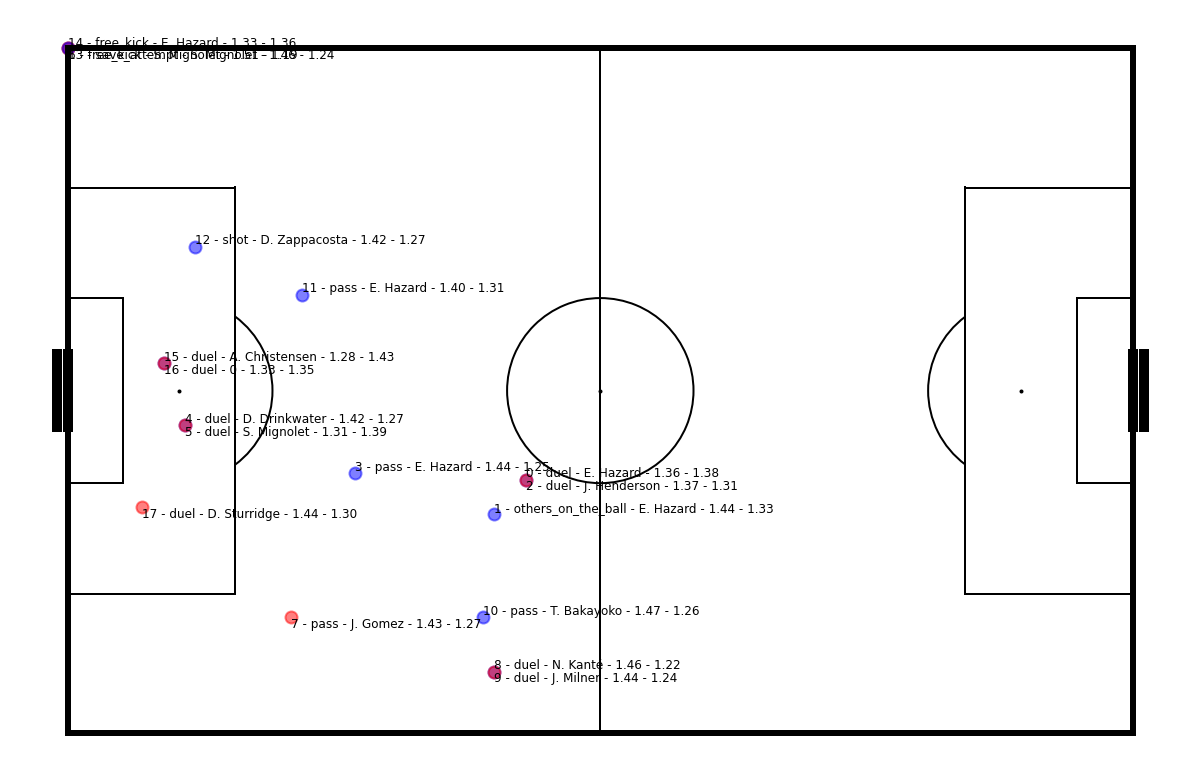

In [18]:
draw.pitch()
for i, row in df.iloc[796579-12:796579+6].reset_index().iterrows():
    row.x = row.x * 100
    row.y = row.y * 100
    if row.team_name == 'Liverpool':
        color='red'
        plt.scatter(row.x, row.y, color=color, alpha=0.5)
        plt.text(row.x, row.y, f'{i} - {row.type_name} - {row.player_name} - {row.exp_pts_home:.2f} - {row.exp_pts_away:.2f}',fontsize=6, va='top')
    elif row.team_name == 'Chelsea':
        color='blue'
        plt.scatter(100-row.x, 100-row.y, color=color, alpha=0.5)
        plt.text(100-row.x, 100-row.y, f'{i} - {row.type_name} - {row.player_name} - {row.exp_pts_home:.2f} - {row.exp_pts_away:.2f}',fontsize=6, va='bottom')